# Changing defaults

Up until now, we've only used the default parameters. Contact Map Explorer always determines contacts based on atom-atom distances, i.e., residues are considered in contact if a pair of an atom from one residue is within a cutoff distance of an atom from another residue. But which atoms? And what is that cutoff distance? These decisions can be customized, and you can get improved performance by customizing them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")
topology = traj.topology

In [2]:
from contact_map import ContactFrequency

## Customizing the atoms involved in the contact

`ContactFrequency` takes the parameters `query` and `haystack`, which are lists of atom indices. It will then search for all contacts between atoms in `query` and atoms in `haystack`. This allows you to, for example, focus on the contacts between two distinct parts of a protein. By only including some atoms in the search, the contacts are calculated more quickly.

This also allows you to fundamentally change the definition of a contact by making it about C$_\alpha$ or about all atoms, instead of heavy atoms as is the default (though if you change that, you should also change the cutoff value). 

In general, it is easiest to get the list of atom indices from MDTraj using its [atom selection language](https://mdtraj.org/1.9.4/examples/atom-selection.html). The default behavior is to look for contacts between all heavy (i.e., non-hydrogen), non-water atoms.

In [3]:
# the default selection is
default_selection = topology.select("not water and symbol != 'H'")
print(len(default_selection))

1408


Note that the general assumption is that the query is no larger than the haystack. If this isn't obeyed, you'll still get correct answers, but some algorithms may be less efficient, and visualizations have also been designed with this in mind.

### Changing the `query`

Now let's focus in on contacts involving specific regions of KRas. In your work, this might be contacts between different parts of one molecule, or contacts between two different molecules, such as in drug binding or DNA-protein interactions. First, let's look at the contacts between the switch 1 region and all other atoms in our default selection. So switch 1 will be our query.

MDTraj allows queries based on different numbering systems: `resid` and `resSeq`. The `resid` is the internally-used residue number, and starts from 0. On the other hand, `resSeq` is the residue number given in the PDB, which usually starts from 1 (and is the number we usually refer to in literature).

In [4]:
switch1 = topology.select("resSeq 32 to 38 and symbol != 'H'")

In [5]:
%%time
sw1_contacts = ContactFrequency(trajectory=traj, query=switch1)

CPU times: user 12.5 s, sys: 7.45 ms, total: 12.5 s
Wall time: 1.09 s


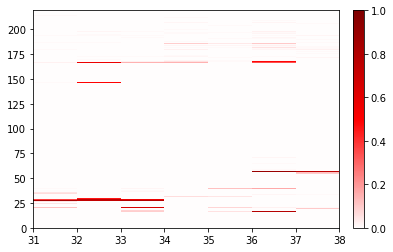

In [6]:
sw1_contacts.residue_contacts.plot();

This shows all contacts of switch 1 with anything else in the system. Here, we automatically zoom in to have query on the `x` axis and the rest on the `y` axis. The boxes are long rectangles instead of squares as in the default selection. The box represents the residue number (in the `resid` numbering system) that is to its left and under it.

### Changing `query` and `haystack`

What if we wanted to zoom in even more, and only look at the contacts between the switch 1 and cations in the system? We make one of the the query and the other the haystack. Since `switch1` contains more atoms than `cations`, we'll use `switch1` as the `haystack`.

In [7]:
cations = topology.select("resname NA or resname MG")

In [8]:
%%time
cations_switch1 = ContactFrequency(trajectory=traj, query=cations, haystack=switch1)

CPU times: user 1.1 s, sys: 10.4 ms, total: 1.11 s
Wall time: 111 ms


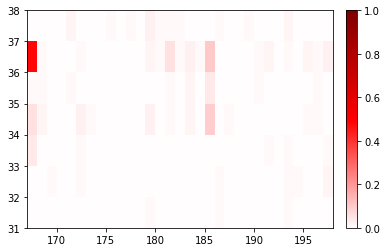

In [9]:
cations_switch1.residue_contacts.plot();

Now we'll plot again, but we'll change the `x` and `y` axes so that we now can see switch 1 along `x` and cations (the query) along `y`:

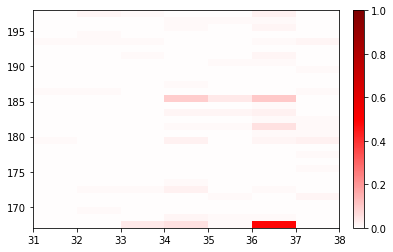

In [10]:
fig, ax = cations_switch1.residue_contacts.plot()
ax.set_xlim(*cations_switch1.haystack_residue_range) 
ax.set_ylim(*cations_switch1.query_residue_range);

Here you can see that the most significant contacts here are between residue 36 and the ion listed as residue 167. Let's see just how frequently that contact is made:

In [11]:
print(cations_switch1.residue_contacts.counter[frozenset([36, 167])])

0.48514851485148514


So about half the time. Now, which residue/ion are these? Remember, these indices start at 0, even though the tradition in science (and the PDB) is to count from 1. Furthermore, the PDB residue numbers for the ions skip the section of the protein that has been removed. But we can easily obtain the relevant residues:

In [12]:
print(topology.residue(36))
print(topology.residue(167))

GLU37
MG202


So this is a contact between the Glu37 and the magnesium ion (which is listed as residue 202 in the PDB).

## Changing the cutoff

Depending on the atoms you use to select contacts, you might choose different cutoff distances. The default cutoff of 0.45 nm is reasonable for heavy atom contacts. However, if you use all atoms (including hydrogens), you'll probably want a smaller cutoff distance. If you use $\textrm{C}_\alpha$ distances, you'll want a larger cutoff distance.

The cutoff distance in controlled using the `cutoff` parameter to `ContactFrequency`. The performance of Contact Map Explorer largely depends on how many atoms are within the cutoff distance, so making the cutoff distance larger while keeping the same number of atoms will have a significant effect.

In [13]:
%%time
large_cutoff = ContactFrequency(trajectory=traj[0], cutoff=1.5)

CPU times: user 1.4 s, sys: 47.2 ms, total: 1.45 s
Wall time: 1.28 s


CPU times: user 6.9 s, sys: 31.8 ms, total: 6.93 s
Wall time: 6.93 s


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

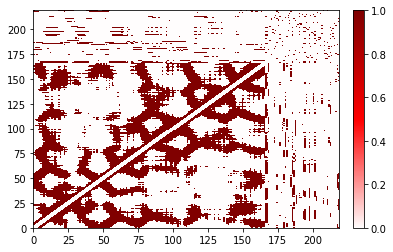

In [14]:
%%time
large_cutoff.residue_contacts.plot();

The larger cutoff leads to a more dense contact matrix. The performance of plotting depends on how dense the contact matrix is -- for tricks to plot dense matrices more quickly, see the documentation on customizing plotting.

## Changing the number of ignored neighbors

By default, Contact Map Explorer ignore atoms from 2 residues on either side of the given residue (and in the same `chain`). This is easily changed. However, even when you say to ignore no neighbors, you still ignore the residue's interactions with itself.

Note: for non-protein contacts, the `chain` is often poorly defined. In this example, the GTP and the Mg are listed sequentially in residue order, and therefore they are considered "neighbors" and their contacts are ignored.

In [15]:
%%time
ignore_none = ContactFrequency(trajectory=traj, n_neighbors_ignored=0)

CPU times: user 20.9 s, sys: 36.6 ms, total: 20.9 s
Wall time: 5.3 s


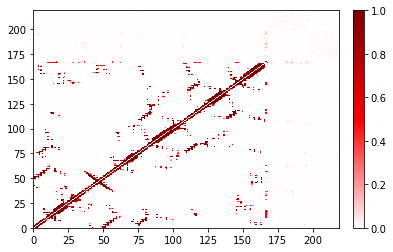

In [16]:
ignore_none.residue_contacts.plot();

## Refresher: The default parameters



* *Which atoms are involved in the contact?* The default value is non-hydrogen, non-water atoms.
* *What is the cutoff distance?* The default value is 0.45 nm.
* *How many neighboring residues are ignored?* The default value is to ignore 2 residues on either side (i±2)